# Classical/ Frequentist Statistical Inference

*N. Hernitschek, 2022*

This is the fifth Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives an introduction to frequentist statistical inference and maximum likelihood estimation.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

as well as on the "Inference" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540) and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Maximum Likelihood Estimation](#first-bullet)
* [Quantifying Estimate Uncertainty](#second-bullet)
* [Fitting a Straight Line to Data](#third-bullet)


## 1. Maximum Likelihood Estimation <a class="anchor" id="first-bullet"></a>

This is another example for MLE using the frequentist approach.

### The Flux of a Star

Imagine that we point our telescope to the sky, and observe the light coming from a single star. We'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{true}$.
We'll also ignore effects leading to systematic errors. 

We perform a series of $N$ measurements with our (perfect) telescope, where the $i^{th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is: Given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux $F_{true}$?

We use Python to generate some toy data to demonstrate the frequentist approaches to the problem (in the next lecture we will compare this to the Bayesian approach). 
As the measurements are number counts, a Poisson distribution is a good approximation to the measurement process:

In [1]:
# Generating some simple photon count data

import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root



We make a simple visualization of the "measured" data:


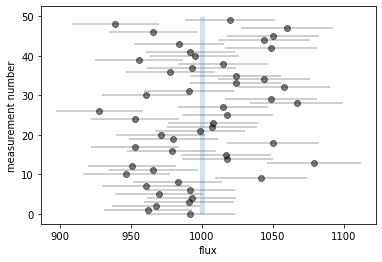

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("flux");ax.set_ylabel("measurement number");


These measurements each have a different error $e_i$ which is estimated from Poisson statistics using the standard square-root rule. Here, as we generate data for this toy example, we already know the true flux $F{_true}$, but the question is this: 

Given our measurements and errors, what is our best estimate of the true flux?

We take here a look at the frequentist approach to solve this problem.

### Frequentist Approach to Estimating the Flux

Given a single observation $D_i=(F_i,e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{true}$ given our assumption of Gaussian errors:

$$P(D_i|F_{true}) = \frac{1}{\sqrt{2\pi e_i^2}}\exp \left( \frac{-(F_i-F_{true})^2}{2e_i^2}     \right)    $$

This should be read "the probability of $D_i$ given $F_{true}$ equals ...". You should recognize this as a normal distribution with mean $F_{true}$ and standard deviation $e_i$.

We then construct the likelihood function for our maximum likelihood approach by computing the product of the probabilities for each data point:

$$L(D|F_{true}) = \prod_{i=1}^N P(D_i|F_{true})$$



Here $D={D_i}$ represents the entire set of measurements. As likelihood values often become very small, it is more convenient to instead compute the log-likelihood. Combining the previous two equations and computing the log, we have

$$
\log L = \frac{1}{2}\sum_{i=1}^N \left[ \log(2 \pi e_i^2)+\frac{(F_i-F_{true})^2}{e_i^2}   \right]
$$


We have to determine $F_{true}$ such that the likelihood is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $d \log L/ d F_{true} =0$). This results in the following observed estimate of $F_{true}$:

$$F_{est} = \frac{\sum w_i F_i}{\sum w_i }    $$ with $w_i=1/e_i^2$

Notice that in the special case of all errors $e_i$ being equal, this reduces to
$$F_{est} = \frac{1}{N} \sum_{i=1}^N F_i$$

That is, in agreement with intuition, $F_{est}$ is simply the mean of the observed data when errors are equal.

We can go further and ask what the error of our estimate is. In the frequentist approach, this can be accomplished by fitting a Gaussian approximation to the likelihood curve at maximum. In this simple case this can also be solved analytically. It can be shown that the standard deviation of this Gaussian approximation is:
    
$$\sigma_{est} = \left(\sum_{i=1}^N w_i \right)^{-1/2}$$

This gives fairly simple calculations; let's evaluate them for our toy dataset:

In [3]:
w = 1. / e ** 2
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N))



      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


We thus find that for 50 measurements of the flux, our estimate has an error of about 0.4% and is consistent with the input value.

(We will see the Bayesian approach to the same problem in the next lecture, lecture notebook 6.)

## Quantifying Estimate Uncertainty <a class="anchor" id="second-bullet"></a>


Our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the shape and distribution of the likelihood function, but we'd like to capture that with a few numbers.

The ***asymptotic normality of MLE*** is invoked to approximate the likelihood function as a Gaussian (or the $\ln L$ as a parabola), i.e. we take a Taylor expansion around the MLE, keep terms up $2^\mathrm{nd}$ order, then *define* the uncertainty on our model parameters as:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The matrix $F$ is known as the **observed Fisher information matrix**. The elements $\sigma^2_{jk}$ are known as the ***covariance matrix***.

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.

In our example of a homoscedastic Gaussian, the uncertainly on the mean is 

$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$

since, again, $\sigma = {\rm constant}$.  

Then 

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you should be familiar with. 

Let's check this:
In the following, we 
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.

First, we are going to draw a homoscedastic sample of ${x_i}$ from a Gaussian and compute the likelihood.

<font color='red'>We generate sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: $\mathscr{N}(\mu,\sigma)$</font>

In [4]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

N = 3
mu = 1.0
sigma = 0.2
np.random.seed(42)
sample = norm(mu,sigma).rvs(size = N)
print(sample)

[1.09934283 0.97234714 1.12953771]


our sample is: [1.09934283 0.97234714 1.12953771]

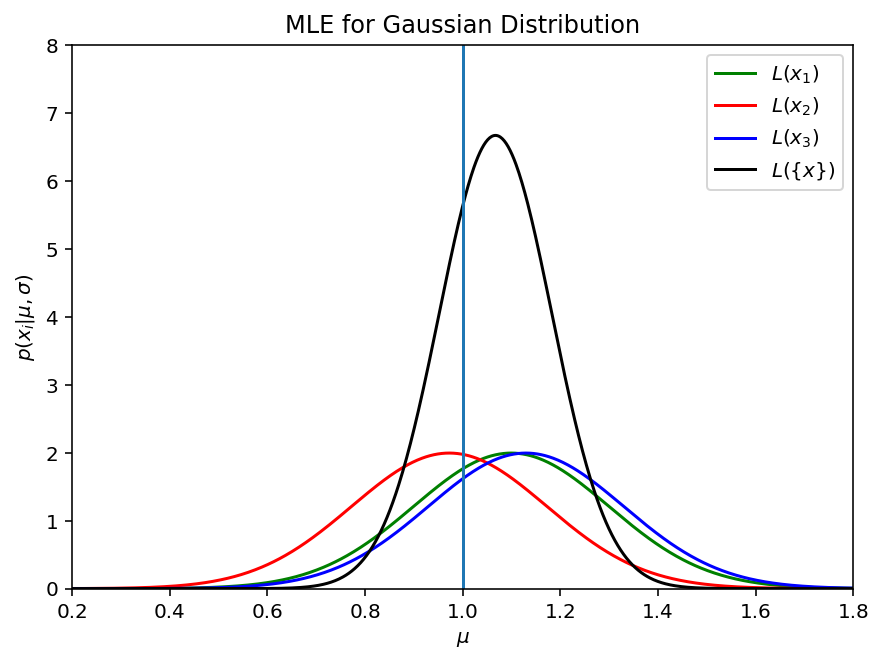

In [5]:
# calculate the likelihoods and plot them
xgrid = np.linspace(0,2,1000)
#here use the locations from above
L1 = norm.pdf(xgrid,loc=1.09934283,scale=0.2) #This is a Gaussian PDF sampled uniformly, centered at a specific location.
L2 = norm.pdf(xgrid,loc=0.97234714,scale=0.2)
L3 = norm.pdf(xgrid,loc=1.12953771,scale=0.2)
L = L1*L2*L3 #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(xgrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\})$')
plt.axvline(x=mu)
plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

We see in this plot that our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the likelihood function.

We now calculate the uncertainties.
<font color='red'>Think about it, and execute the following cell</font>

In [6]:
sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

estimate_mu = xgrid[np.argmax(L)]
print("Likelihood is maximized at %.3f" % estimate_mu)
print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Likelihood is maximized at 1.067
Fisher matrix error on estimated mean is 0.115


Let's plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution for the three data points above.

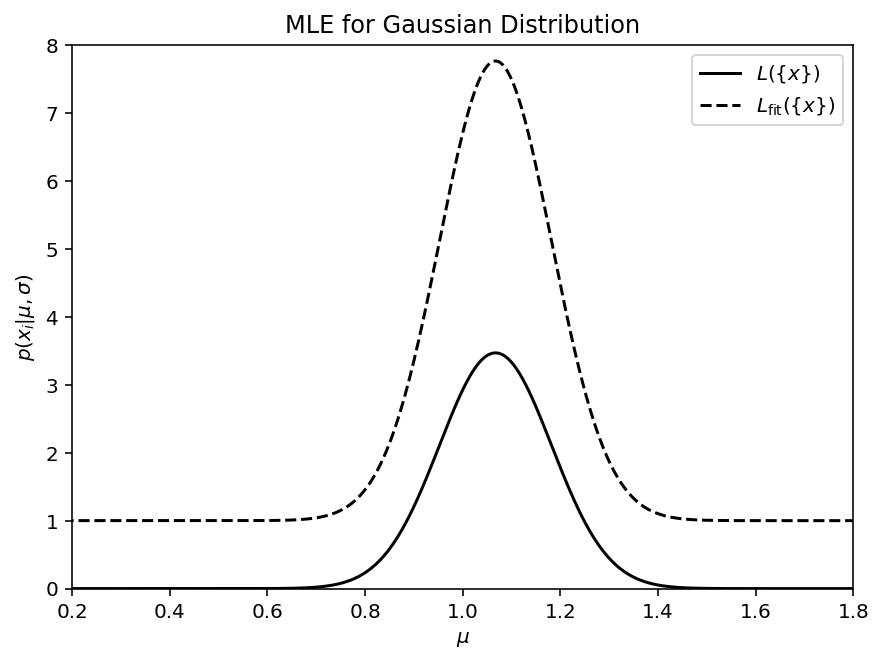

In [7]:
# Execute the following cell

xgrid = np.linspace(0.0,2.0,1000)
L = np.prod([L1,L2,L3],axis=0) # Total L is ???
# complete the following for measured mean and Fisher error
Lfit = norm.pdf(xgrid,loc=estimate_mu,scale=0.115)  

fig, ax = plt.subplots(figsize=(7, 5))

# plot numerical likelihood
plt.plot(xgrid, Lfit, ls='-', c='black', 
         label=r'$L(\{x\})$')

# plot fitted Gaussian with arbitrary normalizing constant
# offset for ease of viewing
C = 1.95
plt.plot(xgrid, C * Lfit + 1.0, ls='dashed', 
         c='black', label=r'$L_\mathrm{fit}(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()


### What is $\pm \sigma$? Errors as Gaussian Approximations to the Likelihood Function

The $(\hat \mu - \sigma_\mu, \hat \mu + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interpr
etation, if we repeated the same measurement a hundred times, we'd find for 68 experiments the true value was within their computed confidence intervals ($1 \sigma$ errors).


## Fitting A Straight Line To Data <a class="anchor" id="third-bullet"></a>

We now look at one of the most common tasks in statistical inference: **fitting a line to data**. We won't always fit a straight line, but they are prevalent in astronomy since we're potentially examining data over several orders of magnitude. Hence power-law relationships ($y\propto x^\alpha$) become linear relationships in log-log space ($\ln y \propto \alpha\ln x + \mathrm{constant}$).

Assume the noise/scatter in our measurements (the residuals) is generated by a Gaussian process, i.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the measurement uncertainty, which we take to be the same for all points. The data model includes a linear relationship with two parameters $a,b$: hence the model is written as $M(a,b)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured. It is just the normal distribution:

$$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right). $$

The likelihood for all data points is given by the product over $N$ of these terms. Given our previous definitions we can then write down the $\ln L$ as

$$ \ln L(a, b) = \mathrm{constant} - \frac{1}{2} \sum_{i=1}^N \frac{(y_i - M(x_i))^2}{\sigma^2} = \mathrm{constant} - \frac{1}{2} \chi^2$$

This is the expression that we now ***maximize*** with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to ***minimizing*** the sum of the squares (the $\chi^2$) in a *least-squares method*.

In [8]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test

The following cell will read in some data and peform a least-squares (or $\chi^2$) fit of a linear relationship. It is minimizing the $\chi^2$ (since this is Gaussian data this means it's also maximizing the likelihood) for both $a$ (the slope) and $b$ (the $y$-intercept). 

The data intentionally contains some **poorly modeled outliers** too, which have very different uncertainties from what we assume. First we'll look at the case **without outliers**. 

***The outlier points are the first 4 in the dataset.***

<font color='red'>Read through and understand the whole thing before you execute it.</font> 

In [9]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

# Define the standard squared-loss function.
# This is just another name for chi^2
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# define a lambda function that defines the sum of squared errors.

# let's first exclude the outliers by chopping off the first 4 points.
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x[4:], y=y[4:], 
                                      dy=dy[4:])

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


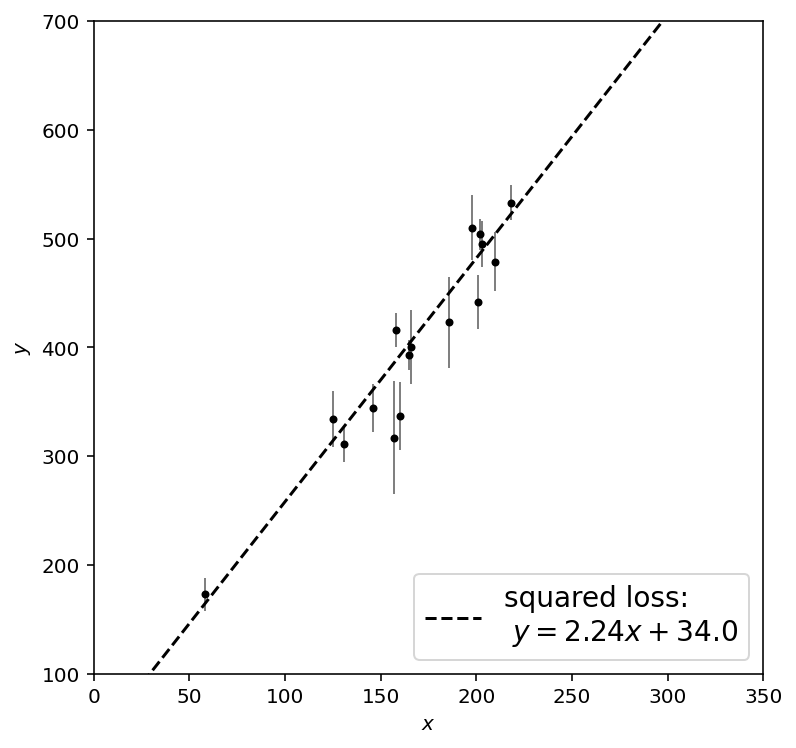

In [10]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

# plot the best fit linear relationship
x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

That's a reasonable fit!

We'll now **include the outlier data points** to see how they contaminate the fit, i.e. we don't need to exclude any of the points from our fit. <font color='red'>Complete and execute the following cell.</font> 

In [11]:
# we include the outliers
f_squared_outlier = lambda beta_outlier: squared_loss(beta_outlier[0], 
                                                      beta_outlier[1], 
                                                      x=x, y=y, dy=dy)

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


<font color='red'>Complete in order to plot the regular and outlier fits on the same figure.</font> 

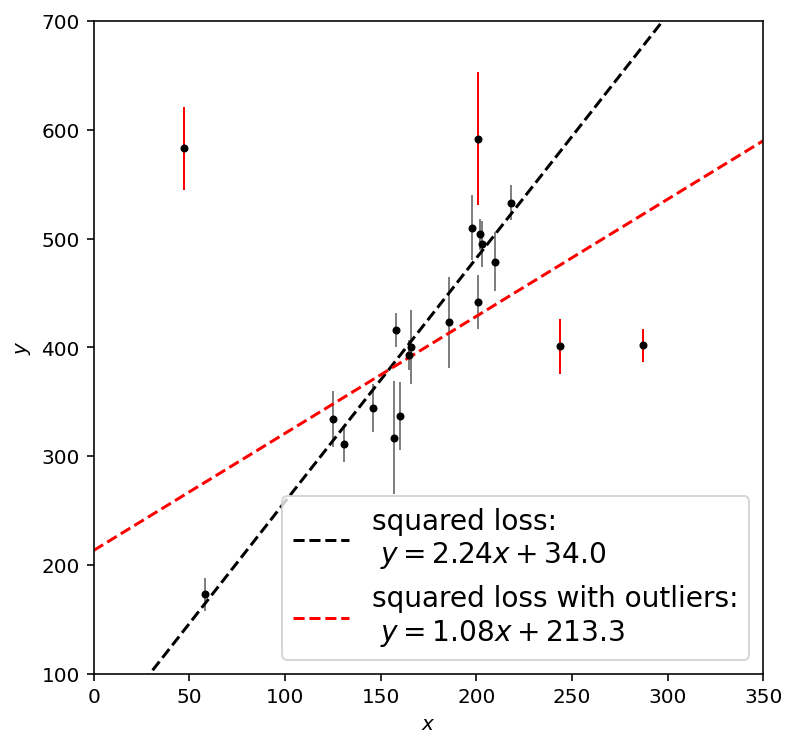

In [12]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[0:4], y[0:4], dy[0:4], 
            fmt='.k', lw=1, ecolor='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1],
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

### How do we deal with outliers: modifying the likelihood

There exist different approaches:

- Summing the squares of the residuals ($\chi^2=\sum_{i=1}^N (y_i - M(x_i))^2/\sigma^2$) is sensitive to outliers.

- The $\chi^2$ is an example of an $L_2$ norm (different L, not the likelihood), where the [$L_p$ norm](https://www.wikiwand.com/en/Lp_space) can be defined as $\sum_{i=1}^N (y_i -M(x_i))^p/\sigma^p$.

- A number of approaches exist for correcting for outliers. See in particular [this](https://arxiv.org/abs/1008.4686) great paper. 

- These include "sigma-clipping", using interquartile ranges (which you've seen in previous lectures), taking the median of solutions of subsets of the data, and least trimmed squares (which searchs for the subset of points that minimizes $\sum_i^N (y_i - \theta_ix_i)^2$).


We can also change the **likelihood** to reduce the weight of outliers. This is known as the **Huber loss function**

$$ \sum_{i=1}^N e(y_i|y),$$

where

$$ 
e(t) = \left\{
            \begin{array}{ll}
            \frac{1}{2} t^2 & \mbox{if} \; |t| \leq c, \\
            c|t| - \frac{1}{2} c^2 & \mbox{if} \; |t| \geq c,
            \end{array}
        \right ) 
$$

and 

$$ t = \left|\frac{y-M(x)}{\sigma}\right|.$$

This is continuous and differentiable, and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large data excursions, which downweights the outlier points.

In the image below, the blue curve is the usual $\chi^2$, $L_2$ parabola shape that we attempt to minimize, whereas the green is the alternative Huber loss function that downweights outliers.

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)

In [13]:
# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points
    
    # apply masking to different points
    # note '~' means 'not'
    return np.sum((~mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)

# lambda function for huber loss 
f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 62
         Function evaluations: 118


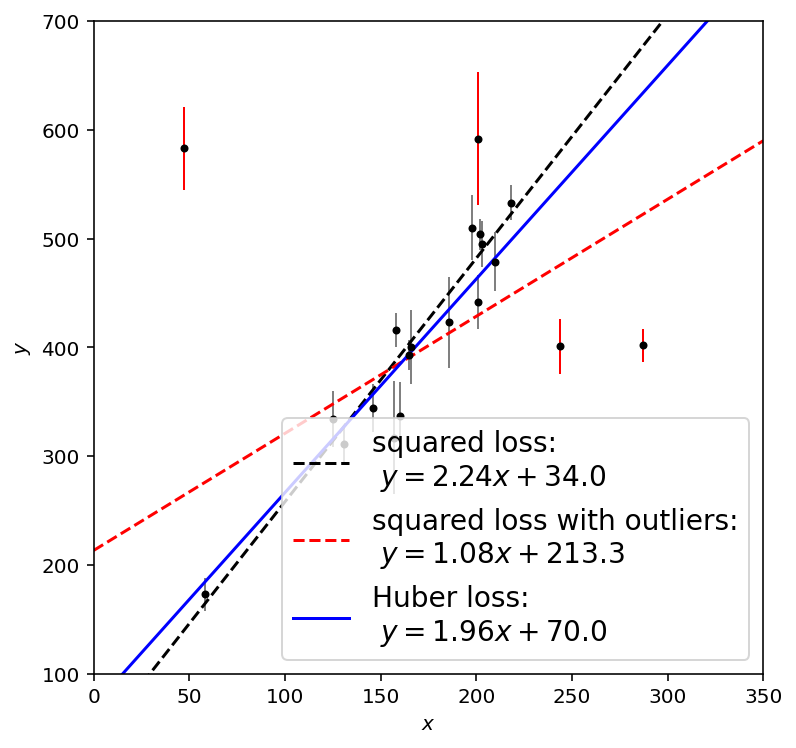

In [14]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.k', lw=1, ecolor='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
# plot the fit with the huber likelihood, downweighting outliers
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], 
        ls='-', color='blue',
        label="Huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

<font color='red'>Does this help with the outliers, and why? Write down what you think about it.</font> 

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* an idea of what Frequentist Statistical Inference means
* an understanding of what Maximum Likelihood Estimation is
* seen how we quantify uncertainties of Maximum Likelihood estimates